# 03 Experiments with pre-defined splits

One of the benefits of the disjoint generative models approach, is the ability to use different models for different subsets of the data. For example using a model that is good for nummerical attributes to model those variables, and using a model that is good for categorical attributes on categorical attributes, etc. However, the best way to partition the data that we found is to distribute highly correlated attributes into *different* partitions, so that the validator models have an easy time reassembling.  

In the following we will show how this can be done to the benefit of the synthetic data quality. 

The example will be based on the [Hepatitis dataset from the UCI repository](https://archive.ics.uci.edu/dataset/503/hepatitis+c+virus+hcv+for+egyptian+patients). The dataset contains ~1300 rows and 29 columns. The columns are a mix of categorical and numerical attributes. The dataset contains no missing values. We report the average metric result and standard error of the mean for 10 repeated rund of the experiment with 80% of the data used for training and 20% for the metrics that require holdout data. Not all results are code is shown in this notebook since we used a different script to run the full experiment on a different machine. The script is [03_results.py](experiments/results/03_vresults.py) and saves the results in the `experiments/results/03_hepatitis_case_study` folder. 

In [ ]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from joblib import Parallel, delayed

from syntheval import SynthEval

from sklearn.ensemble import RandomForestClassifier
from disjoint_generation import DisjointGenerativeModels
from disjoint_generation.utils.joining_validator import JoiningValidator
from disjoint_generation.utils.joining_strategies import UsingJoiningValidator, Concatenating
from disjoint_generation.utils.generative_model_adapters import generate_synthetic_data

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "pca"       : {},
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"  : {"num_eval_iter": 5},
}

In [ ]:
from disjoint_generation.utils.dataset_manager import DataManager

### Load training and testing datasets and define categorical and numerical attributes

df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

# dm = DataManager(df_train, automated_splits = "correlated", num_automated_splits = 2)
# predefined_splits = dm.column_splits

predefined_splits = {
    'split0': ['RNA EOT', 'ALT 24', 'Diarrhea', 'BMI', 'Epigastric pain', 'Age', 'Headache', 'Plat', 'Fatigue & generalized bone ache', 
               'AST 1', 'Nausea/Vomting', 'Gender', 'ALT 36', 'Fever', 'RNA Base', 'b_class'], 
    'split1': ['RNA EF', 'ALT 48', 'HGB', 'Jaundice', 'RNA 12', 'ALT 1', 'ALT 12', 'ALT 4', 'RNA 4', 
               'Baseline histological Grading', 'RBC', 'ALT after 24 w', 'WBC']
               }

print(predefined_splits)
df_train.head()

{'split0': ['RNA EOT', 'ALT 24', 'Diarrhea', 'BMI', 'Epigastric pain', 'Age', 'Headache', 'Plat', 'Fatigue & generalized bone ache', 'AST 1', 'Nausea/Vomting', 'Gender', 'ALT 36', 'Fever', 'RNA Base', 'b_class'], 'split1': ['RNA EF', 'ALT 48', 'HGB', 'Jaundice', 'RNA 12', 'ALT 1', 'ALT 12', 'ALT 4', 'RNA 4', 'Baseline histological Grading', 'RBC', 'ALT after 24 w', 'WBC']}


,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,b_class
0,47,2,32,2,2,1,2,2,2,2,...,87,56,39,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",11,1
1,36,2,24,2,1,2,2,2,1,2,...,108,74,45,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",3,1
2,50,1,34,1,1,2,1,2,2,2,...,71,125,28,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",9,1
3,32,2,30,1,2,1,2,2,1,1,...,102,84,40,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",6,0
4,58,1,29,2,2,1,1,2,2,1,...,55,40,40,"(5, 1201086]","(5, 1201715]","(0, 5]","(0, 5]","(0, 5]",15,1


In [3]:
### Background measurement
SE = SynthEval(df_train, df_test, verbose=False)
SE.evaluate(df_train, analysis_target_var=label,**metrics)

,metric,dim,val,err,n_val,n_err
0,pca_eigval_diff,u,0.000000e+00,NaN,1.000000,NaN
1,pca_eigvec_ang,u,3.420361e-08,NaN,1.000000,NaN
2,avg_h_dist,u,0.000000e+00,0.000000,1.000000,0.000000
3,corr_mat_diff,u,0.000000e+00,NaN,1.000000,NaN
4,auroc,u,0.000000e+00,NaN,0.761594,NaN
5,avg_F1_diff,u,0.000000e+00,0.008192,1.000000,0.008192
6,avg_F1_diff_hout,u,0.000000e+00,0.000000,1.000000,0.000000
7,eps_identif_risk,p,0.000000e+00,NaN,1.000000,NaN
8,priv_loss_eps,p,-2.090498e-01,NaN,0.790950,NaN
9,median_DCR,p,1.000000e+00,NaN,0.761594,NaN


In [9]:
def model_experiment(df_train: DataFrame, df_test: DataFrame, label: str, model: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of a generative model on the same 
    dataset and return best estimate of the mean of the various metrics. 
    """
    SE = SynthEval(df_train, df_test, verbose=False)

    dfs_list = Parallel(n_jobs=-1)(delayed(generate_synthetic_data)(df_train, model, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}
    
    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
cart_results = model_experiment(df_train, df_test, label, 'synthpop', metrics)
cart_results.to_csv('experiments/results/03_hepatitis_case_study/synthpop.csv')

In [ ]:
bn_results = model_experiment(df_train, df_test, label, 'datasynthesizer-dp', metrics)
bn_results.to_csv('experiments/results/03_hepatitis_case_study/datasynthesizer.csv')
#~12 mins

In [ ]:
dpgan_results = model_experiment(df_train, df_test, label, 'dpgan', metrics)
dpgan_results.to_csv('experiments/results/03_hepatitis_case_study/dpgan.csv')

### Now do the many combinations of mixed models
We use synthpop and DataSynthesizer for the categorical attributes and CTGAN, ADSGAN and DPGAN for the nummerical attributes.
See the code for calibration and optimisation steps in the [Codebook 4](04_joining_validator.ipynb), here we just show the calibration plot:

![Calibration Plot](plots/cal_curve_rf_optimal.png)

In [6]:
import pickle
from typing import Literal

def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], joining_strat: str, id) -> DataFrame:
    """ Function to do runs of the mixed model. """

    if joining_strat == 'valid':
        with open('experiments/validator_models/hp_rf_opt.obj', 'rb') as file:
            joining_validator = pickle.load(file)
        
        JS = UsingJoiningValidator(joining_validator, behaviour='adaptive')
    elif joining_strat == 'concat':
        JS = Concatenating()
    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, parallel_worker_id=id*10)
    dgms.join_multiplier = 4

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           partitions: Dict[str, List[str]], label: str, joining_strat: Literal['concat', 'valid'],
                           metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, partitions,joining_strat, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'dpgan', predefined_splits, label, "valid", metrics)
df_dgms.to_csv('experiments/results/03_hepatitis_case_study/synthpop_dpgan_valid.csv')
#~9 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'datasynthesizer-dp', predefined_splits, label,"valid", metrics)
df_dgms.to_csv('experiments/results/03_hepatitis_case_study/synthpop_datasynthesizer_valid.csv')
#~17 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'dpgan', predefined_splits, label, metrics)
df_dgms.to_csv('experiments/results/03_hepatitis_case_study/datasynthesizer_dpgan.csv')
#~11 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer-dp', 'dpgan', predefined_splits, label,"valid", metrics)
df_dgms.to_csv('experiments/results/03_hepatitis_case_study/datasynthesizer_dpgan_valid.csv')
#~22 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'dpgan', 'synthpop', predefined_splits, label, "valid", metrics)
df_dgms.to_csv('experiments/results/03_hepatitis_case_study/dpgan_synthpop_valid.csv')
#~13 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'dpgan', 'datasynthesizer-dp', predefined_splits, label, "valid", metrics)
df_dgms.to_csv('experiments/results/03_hepatitis_case_study/dpgan_datasynthesizer_valid.csv')
#~17 mins

In [ ]:
import pandas as pd

join_type = 'valid' # 'concat' or 'valid'

### Read all the results and present them in a joint dataframe
res_dfs = {
    'sp': pd.read_csv('experiments/results/03_hepatitis_case_study/synthpop.csv', index_col=0),
    'ds': pd.read_csv('experiments/results/03_hepatitis_case_study/datasynthesizer.csv', index_col=0),
    'dpgan': pd.read_csv('experiments/results/03_hepatitis_case_study/dpgan.csv', index_col=0),
    'sp_sp' : pd.read_csv(f'experiments/results/03_hepatitis_case_study/synthpop_synthpop_{join_type}.csv', index_col=0),
    'ds_ds' : pd.read_csv(f'experiments/results/03_hepatitis_case_study/datasynthesizer_datasynthesizer_{join_type}.csv', index_col=0),
    'dp_dp' : pd.read_csv(f'experiments/results/03_hepatitis_case_study/dpgan_dpgan_{join_type}.csv', index_col=0),
    'sp_ds': pd.read_csv(f'experiments/results/03_hepatitis_case_study/synthpop_datasynthesizer_{join_type}.csv', index_col=0),
    'sp_dp': pd.read_csv(f'experiments/results/03_hepatitis_case_study/synthpop_dpgan_{join_type}.csv', index_col=0),
    'ds_sp': pd.read_csv(f'experiments/results/03_hepatitis_case_study/datasynthesizer_synthpop_{join_type}.csv', index_col=0),
    'ds_dp': pd.read_csv(f'experiments/results/03_hepatitis_case_study/datasynthesizer_dpgan_{join_type}.csv', index_col=0),
    'dp_sp': pd.read_csv(f'experiments/results/03_hepatitis_case_study/dpgan_synthpop_{join_type}.csv', index_col=0),
    'dp_ds': pd.read_csv(f'experiments/results/03_hepatitis_case_study/dpgan_datasynthesizer_{join_type}.csv', index_col=0),
}

In [10]:
### Create a joint dataframe with all the results

df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
sp    mean         0.022486        0.429171    0.005824       0.397188   
      sem          0.001913        0.064443    0.000363       0.013880   
ds    mean         0.076919        0.897412    0.102012       2.883638   
      sem          0.004250        0.025681    0.005283       0.089107   
dpgan mean         0.276939        0.853898    0.273214       2.677029   
      sem          0.027209        0.057231    0.004388       0.024712   
sp_sp mean         0.030578        0.555947    0.016941       0.594092   
      sem          0.002048        0.045851    0.000646       0.020790   
ds_ds mean         0.067808        0.812508    0.097236       2.440393   
      sem          0.003115        0.039554    0.003896       0.104990   
dp_dp mean         0.197213        0.847303    0.283900       2.564147   
      sem          0.018133        0.063154    0.006287       0.030305   
sp_ds mean         0.059510        0.538379    0.058159       2.082966   
      sem          0.001684        0.040853    0.001737       0.084160   
sp_dp mean         0.304867        0.551287    0.139017       2.219946   
      sem          0.021649        0.046240    0.004626       0.047308   
ds_sp mean         0.040832        0.812581    0.047887       1.331779   
      sem          0.002719        0.051483    0.002200       0.132695   
ds_dp mean         0.270799        0.763522    0.188470       2.594137   
      sem          0.022381        0.071894    0.008850       0.061420   
dp_sp mean         0.271105        0.658358    0.167432       2.315404   
      sem          0.016760        0.088350    0.005935       0.079944   
dp_ds mean         0.236526        0.867558    0.223258       2.380949   
      sem          0.014885        0.026798    0.007965       0.120389   

               auroc  avg_F1_diff  avg_F1_diff_hout  eps_identif_risk  \
sp    mean -0.015672    -0.082641         -0.006652          0.561357   
      sem   0.008859     0.002381          0.002493          0.003445   
ds    mean  0.003009    -0.083629          0.012650          0.277919   
      sem   0.011842     0.005835          0.009039          0.006518   
dpgan mean  0.014446    -0.303937         -0.214673          0.027240   
      sem   0.011318     0.013304          0.012996          0.008311   
sp_sp mean  0.007781    -0.075530          0.000097          0.534661   
      sem   0.012211     0.002191          0.002571          0.003528   
ds_ds mean  0.003252    -0.087933          0.000677          0.317104   
      sem   0.008265     0.013044          0.017393          0.008738   
dp_dp mean  0.000755    -0.271221         -0.185870          0.047511   
      sem   0.011025     0.023048          0.024587          0.006958   
sp_ds mean  0.017560    -0.072827          0.007711          0.362805   
      sem   0.012374     0.003821          0.003728          0.007005   
sp_dp mean  0.015698    -0.082087          0.002231          0.131946   
      sem   0.010343     0.009227          0.004428          0.023589   
ds_sp mean  0.044735    -0.095685          0.006511          0.473937   
      sem   0.010824     0.014578          0.013059          0.006554   
ds_dp mean  0.034218    -0.105663         -0.000138          0.145792   
      sem   0.011049     0.020501          0.015693          0.025303   
dp_sp mean  0.000940    -0.228531         -0.143346          0.140905   
      sem   0.014183     0.039666          0.040680          0.025333   
dp_ds mean  0.010712    -0.236345         -0.150511          0.113846   
      sem   0.011005     0.038280          0.036466          0.011358   

            priv_loss_eps  median_DCR  mia_recall  mia_precision  
sp    mean       0.361176    0.954180    0.527246       0.527819  
      sem        0.002860    0.002043    0.012616       0.007894  
ds    mean       0.125339    1.612000    0.022319       0.490916  
      sem        0.004977    0.020428    0.004365       0.065501  


In [11]:
df_results.T.to_latex('experiments/results/03_hepatitis_case_study/results.tex', float_format="%.6f")

In [13]:
df_res = df_results.drop(columns=[col for col in df_results.columns if 'sem' in col])

df_res.columns = df_res.columns.droplevel(1)
df_res = df_res.T

# group by metrics that need to me maximised and those that need to be minimized
df_max = df_res[['auroc', 'avg_F1_diff', 'avg_F1_diff_hout','median_DCR']].copy().T
df_min = df_res[['pca_eigval_diff', 'pca_eigvec_ang', 'avg_h_dist', 'corr_mat_diff',
                 'eps_identif_risk', 'priv_loss_eps', 'mia_recall', 'mia_precision']].copy().T

Friedman test statistic: 5.913702623906704, p-value = 0.8790597176499437


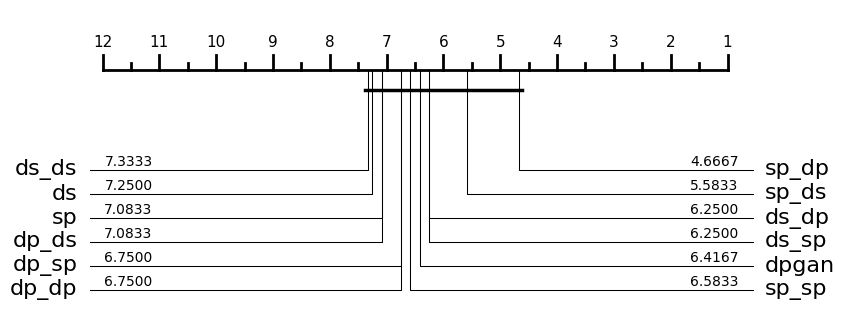

In [14]:
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference
from scipy.stats import friedmanchisquare

df_max_ranks = df_max.rank(axis=1, method='min', ascending=False)
df_min_ranks = df_min.rank(axis=1, method='min', ascending=True)
df_ranks = pd.concat([df_max_ranks, df_min_ranks], axis=0)

pvals = plot_critical_difference(
        df_ranks.values, 
        df_ranks.columns.tolist(), 
        lower_better=True,
        test='wilcoxon',  # or nemenyi
        correction='holm', # or bonferroni or none
        width=8,
        alpha=0.1,
        return_p_values=True,
    )
friedman_stat, p_value = friedmanchisquare(*df_ranks.T.values)
print(f"Friedman test statistic: {friedman_stat}, p-value = {p_value}")

plt.gca()
plt.savefig('experiments/figures/figure_hepatitis_cdd.pdf', bbox_inches='tight')

## Results for other datasets
We repeated the additional datasets using the DataSynthesizer-DPGAN DGM. The results are shown in the figure.

In [ ]:
import json
import pickle

import pandas as pd

from typing import Literal, Dict, List
from pandas import DataFrame

from disjoint_generation import DisjointGenerativeModels
from disjoint_generation.utils.dataset_manager import DataManager
from disjoint_generation.utils.joining_validator import JoiningValidator
from disjoint_generation.utils.joining_strategies import UsingJoiningValidator
    
def generate_partitions(dataset_name: str, df_train: DataFrame, label_var: str):
    """ Function to generate partitions for the dataset. """

    dm = DataManager(df_train, automated_splits = "correlated", num_automated_splits = 2)
    predefined_splits = dm.column_splits

    if label_var in predefined_splits['split1']:
        predefined_splits['split0'], predefined_splits['split1'] = predefined_splits['split1'], predefined_splits['split0']

    # save results
    with open(f"experiments/results/other_datasets_adapt/{dataset_name}_corr_parts.json", "w") as f:
        json.dump(predefined_splits, f)

    return predefined_splits

def autotune(dataset_name: str, df_train: DataFrame, partitions: Dict[str, List[str]],
             validator_name:str, validator_model: object, 
             parameter_grid: dict, 
             calibration_method: Literal['sigmoid', 'isotonic'] | None
             ) -> None:
    """ Function to autotune the joining validator. """
    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train,['temp_1', 'temp_2'], partitions, joining_strategy=JS)
    dgms.num_samples = 20 
    dgms._setup()
    
    dgms._make_calibration_plot(df_test, save=False, stats=True)

    with open(f'experiments/validator_models/{dataset_name}_{validator_name}_opt.obj', 'wb') as file:
        pickle.dump(dgms._strategy.join_validator, file)
    pass

DataManager: The exterior correlations are 1.33 times that of the interiors.
DataManager: The exterior correlations are 1.33 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.688773 using {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 15}
Validator: Calibration improved the model from 0.9719 to 0.9720


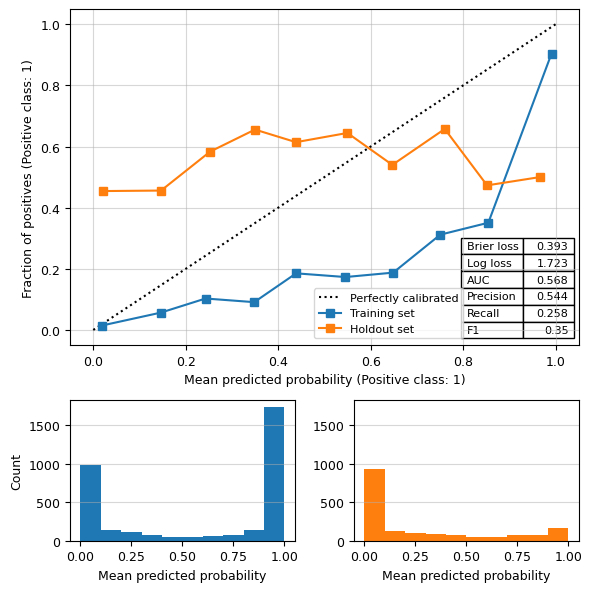

In [311]:
# Alzheimer's dataset
from sklearn.ensemble import RandomForestClassifier

dataset_name = 'al'
label_var = 'Diagnosis'

df_train = pd.read_csv('experiments/datasets/alzheimers_train.csv')
df_test = pd.read_csv('experiments/datasets/alzheimers_test.csv')

parts = generate_partitions(dataset_name, df_train, label_var)

parameter_grid = {
    'n_estimators': [5, 10, 15, 16], 'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['sqrt', 'log2']
}
calibration_method = 'sigmoid'

autotune(dataset_name, df_train, parts, 'rf', RandomForestClassifier(), parameter_grid, calibration_method)


DataManager: The exterior correlations are 1.65 times that of the interiors.
DataManager: The exterior correlations are 1.65 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.924433 using {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 15}
Validator: Calibration improved the model from 0.9522 to 0.9604


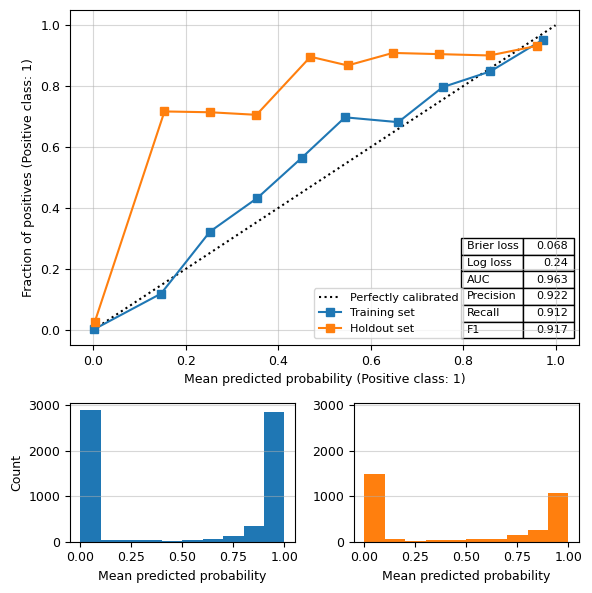

In [312]:
# Breast cancer dataset
from sklearn.ensemble import RandomForestClassifier

dataset_name = 'bc'
label_var = 'Status'

df_train = pd.read_csv('experiments/datasets/breast_cancer_train.csv')
df_test = pd.read_csv('experiments/datasets/breast_cancer_test.csv')

parts = generate_partitions(dataset_name, df_train, label_var)

parameter_grid = {
    'n_estimators': [5, 10, 15, 16], 'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['sqrt', 'log2']
}
calibration_method = 'sigmoid'

autotune(dataset_name, df_train, parts, 'rf', RandomForestClassifier(), parameter_grid, calibration_method)

DataManager: The exterior correlations are 1.41 times that of the interiors.
DataManager: The exterior correlations are 1.41 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.850187 using {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Validator: Calibration improved the model from 0.9302 to 0.9343


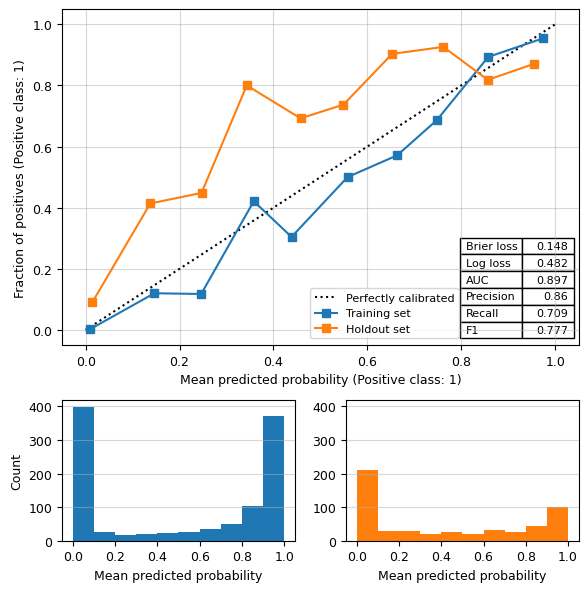

In [314]:
# Cervical cancer dataset
from sklearn.ensemble import RandomForestClassifier

dataset_name = 'cc'
label_var = 'Biopsy'

df_train = pd.read_csv('experiments/datasets/cervical_cancer_train.csv')
df_test = pd.read_csv('experiments/datasets/cervical_cancer_test.csv')

parts = generate_partitions(dataset_name, df_train, label_var)

parameter_grid = {
    'n_estimators': [5, 10, 15, 20], 'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['sqrt', 'log2']
}
calibration_method = 'sigmoid'

autotune(dataset_name, df_train, parts, 'rf', RandomForestClassifier(), parameter_grid, calibration_method)

DataManager: The exterior correlations are 1.23 times that of the interiors.
DataManager: The exterior correlations are 1.23 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.707645 using {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 15}
Validator: Calibration did not improve the model. Using the original model.


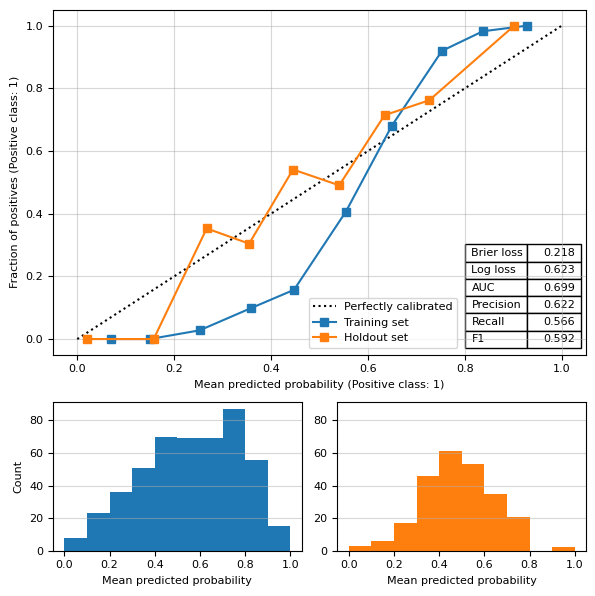

In [ ]:
# Heart Disease dataset
from sklearn.ensemble import RandomForestClassifier
dataset_name = 'hd'
label_var = 'target'

df_train = pd.read_csv('experiments/datasets/heart_train.csv')
df_test = pd.read_csv('experiments/datasets/heart_test.csv')

parts = generate_partitions(dataset_name, df_train, label_var)

parameter_grid = {
    'n_estimators': [5, 10, 15], 'max_depth': [5, 10],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['sqrt', 'log2']
}
calibration_method = 'sigmoid'

autotune(dataset_name, df_train, parts, 'rf', RandomForestClassifier(), parameter_grid, calibration_method)

DataManager: The exterior correlations are 1.08 times that of the interiors.
DataManager: The exterior correlations are 1.08 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.724206 using {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
Validator: Calibration improved the model from 0.9414 to 0.9442


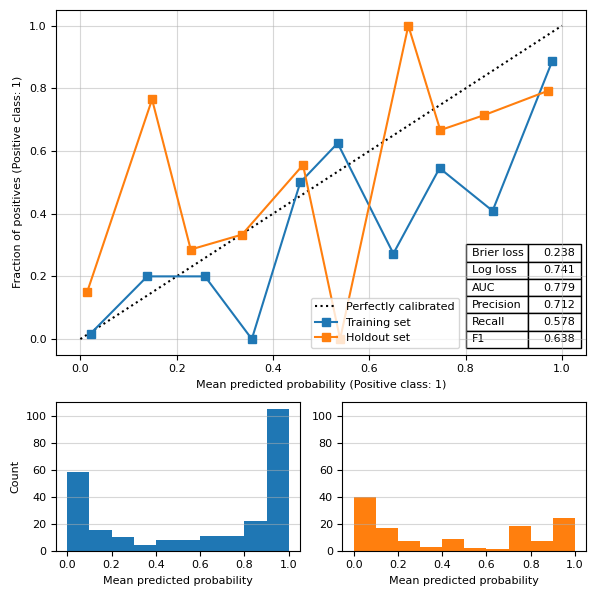

In [29]:
# Kidney Disease dataset
from sklearn.ensemble import RandomForestClassifier
dataset_name = 'kd'
label_var = 'class'

df_train = pd.read_csv('experiments/datasets/kidney_disease_train.csv')
df_test = pd.read_csv('experiments/datasets/kidney_disease_test.csv')

parts = generate_partitions(dataset_name, df_train, label_var)

parameter_grid = {
    'n_estimators': [5, 10], 'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['sqrt', 'log2']
}
calibration_method = 'sigmoid'

autotune(dataset_name, df_train, parts, 'rf', RandomForestClassifier(), parameter_grid, calibration_method)

DataManager: The exterior correlations are 1.40 times that of the interiors.
DataManager: The exterior correlations are 1.40 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.749809 using {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Validator: Calibration improved the model from 0.9102 to 0.9326


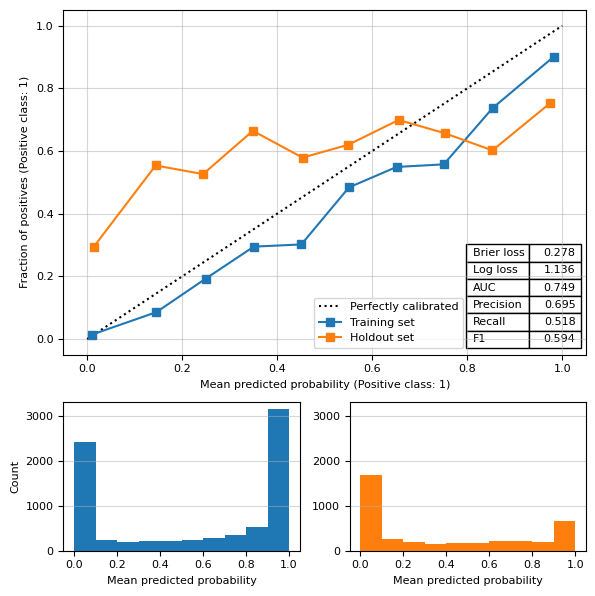

In [30]:
# Stroke dataset
from sklearn.ensemble import RandomForestClassifier

dataset_name = 'st'
label_var = 'stroke'

df_train = pd.read_csv('experiments/datasets/stroke_train.csv')
df_test = pd.read_csv('experiments/datasets/stroke_test.csv')

parts = generate_partitions(dataset_name, df_train, label_var)

parameter_grid = {
    'n_estimators': [5, 10, 15, 20], 'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': ['sqrt', 'log2']
}
calibration_method = 'sigmoid'

autotune(dataset_name, df_train, parts, 'rf', RandomForestClassifier(), parameter_grid, calibration_method)

### Analysis of the results

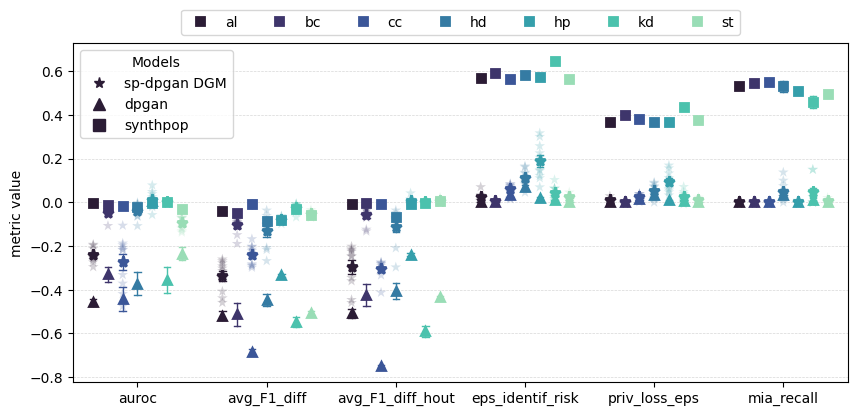

In [ ]:
### Figure 6

from experiments.auxiliaries.plotting import make_relative_derviation_histogram

datasets = ['al', 'bc', 'cc', 'hd', 'hp', 'kd', 'st']
make_relative_derviation_histogram(datasets, models=['synthpop', 'dpgan'])